In [1]:
from ml_fingerprint import ml_fingerprint, example_models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import csv
import pandas as pd


model, score = example_models.rain_classifier()

In [2]:

dataset = pd.read_csv('datasets/weatherAUS.csv')

# Drop the RISK_MM column following the dataset owner recomendation for classifiers.
dataset.drop('RISK_MM', axis=1, inplace=True)

# Through recursive testing, we have determined that these columns have little to no impact
# on the precision of the model.
# The score only drops a mere 0.03% when deleting these columns, from 0.8495 to 0.8491.
droppable_cols = ['MinTemp', 'Evaporation', 'WindDir9am', 'WindSpeed9am', 'Temp3pm',
                'RainToday', 'MaxTemp', 'Sunshine', 'WindGustDir', 'Humidity9am',
                'Cloud9am', 'Temp9am', 'WindDir3pm']
for col in droppable_cols:
    dataset.drop(col, axis=1, inplace=True)

# Dividing columns in numerical and categorical
categorical = []
numerical = []
for col in dataset.columns:
    if dataset.dtypes[col] == 'O':
        categorical.append(col)
    else:
        numerical.append(col)

# Convert Date to separate year, month and day values
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Day'] = pd.to_datetime(dataset['Date']).dt.day
# Drop Date column, as we don't need it anymore
dataset.drop('Date', axis=1, inplace=True)
categorical.remove('Date')
numerical.append('Year')
numerical.append('Month')
numerical.append('Day')

# Limiting all numerical outliers to a maximum value, set to 3 interquantile ranges (IQR) starting from 75%.
for col in numerical:
    IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    max_outlier = dataset[col].quantile(0.75) + (IQR * 3)
    #print(col + ", max: " + str(max_outlier) + ", count: " + str(np.where(dataset[col]>max_outlier, 1, 0).sum()))
    dataset[col] = np.where(dataset[col]>max_outlier, max_outlier, dataset[col])

# Fill the NaN numerical values with median
for col in numerical:
    col_median=dataset[col].median()
    dataset[col].fillna(col_median, inplace=True)

# Fill the NaN categorical values with mode
for col in categorical:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

# Setting Y value as whether if it will rain tomorrow or not, and dropping it from main dataset.
Y = dataset['RainTomorrow']
dataset.drop('RainTomorrow', axis=1, inplace=True)
categorical.remove('RainTomorrow')


# Setting X value as all the other columns, converting the categorical ones into dummy values 
# Dummy values are binary columns for each category in the original column, for whether the row 
# belongs to that category or not.
X = dataset[numerical]
list_X = [X]
for col in categorical:
    list_X.append(pd.get_dummies(dataset[col]))
X = pd.concat(list_X, axis=1)

# Normalize all data
cols = X.columns
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=[cols])

# Split X and Y data into train and test, with a 70%/30% ratio.
# This also randomizes the data order before splitting the top 70% and the last 30%.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

# instantiate the model
model = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)



[[0.73561817 0.03882039]
 [0.11207745 0.11348399]]


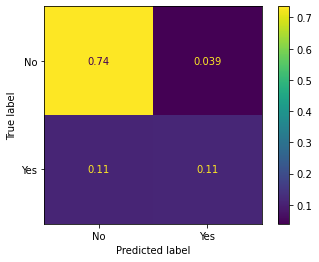

In [3]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

print(confusion_matrix(y_test, y_pred_test)/len(y_test))

con = plot_confusion_matrix(model, X_test, y_test, normalize="all")
con.figure_.savefig('confusion.png', dpi=300)

In [4]:
y_testb = np.where(y_test == "No", 0, 1)
y_pred_testb = np.where(y_pred_test == "No", 0, 1)
print(y_pred_test)

['No' 'No' 'No' ... 'No' 'No' 'No']


In [5]:
f1_score(y_testb, y_pred_testb)

0.6006576090328184

C:\Users\jaime\Miniconda3\envs\tfg\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


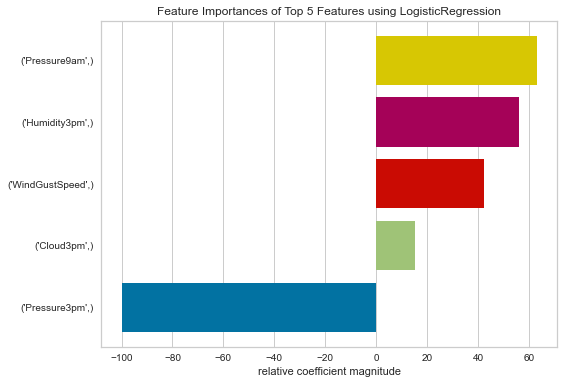

<AxesSubplot:title={'center':'Feature Importances of Top 5 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [10]:
from yellowbrick.model_selection import FeatureImportances
viz = FeatureImportances(model, topn=5)
viz.fit(X, Y)
viz.show()

In [19]:
import matplotlib.pyplot as plt


In [18]:
viz.fig.savefig('features.png', dpi=300)

In [20]:
import sympy as sym

In [21]:
tp = sym.Symbol('tp')
fp = sym.Symbol('fp')
fn = sym.Symbol('fn')

In [25]:
pre = tp/(tp+fp)
ex = tp/(tp+fn)

In [28]:
f = 2*pre*ex/(pre+ex)

In [29]:
sym.simplify(f)

2*tp/(fn + fp + 2*tp)